# Proyecto Final - IA - Machine Learning
## Arquitectura 1: Multi-Layer Perceptron (MLP) para Clasificación de Calidad de Vino

**Dataset:** Wine Reviews (Kaggle)  
https://www.kaggle.com/datasets/zynicide/wine-reviews


Red neuronal MLP para clasificar la calidad del vino en varias categorias a partir de algunos atributos presentes en el dataset.

## 1. Introducción y Objetivo

### Descripción del problema

Se quiere **predecir la calidad del vino** usando información disponible en el dataset Wine Reviews. El dataset contiene reseñas de vinos de diferentes países, variedades, bodegas, junto con el puntaje asignado (en una escala aproximada de 80 a 100 puntos).

En lugar de predecir el valor exacto de `points` (regresión), se hará una **clasificación** en categorías de calidad:

- Clase 0 — Calidad media (puntos entre 80 y 86)
- Clase 1 — Buena calidad (puntos entre 87 y 90)
- Clase 2 — Muy buena / excelente (puntos ≥ 91)

### ¿Por qué este dataset?

- Es parte de los datasets recomendados.
- Se utiliza bastante
- Es suficientemente grande.

### Imports e inicializacion

In [ ]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Configuración general
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

### Carga del dataset



In [ ]:
# Cargamos el dataset directamente desde kagglehub en lugar del archivo csv descargado
file_path = "winemag-data-130k-v2.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path,
)
df.head()

Using Colab cache for faster access to the 'wine-reviews' dataset.


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Exploracion de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


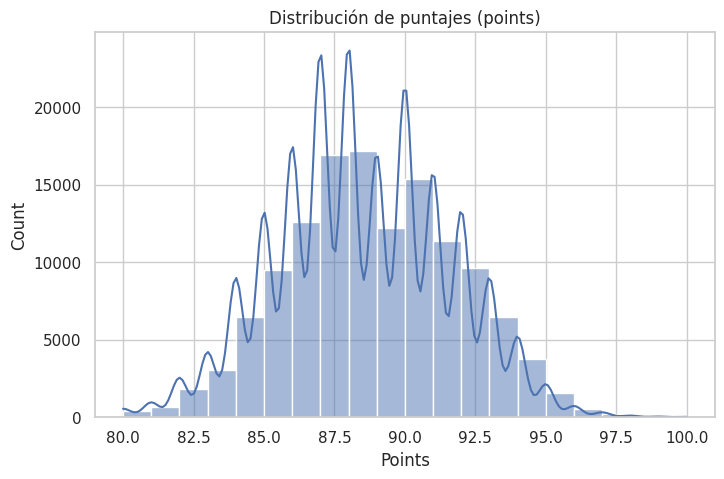

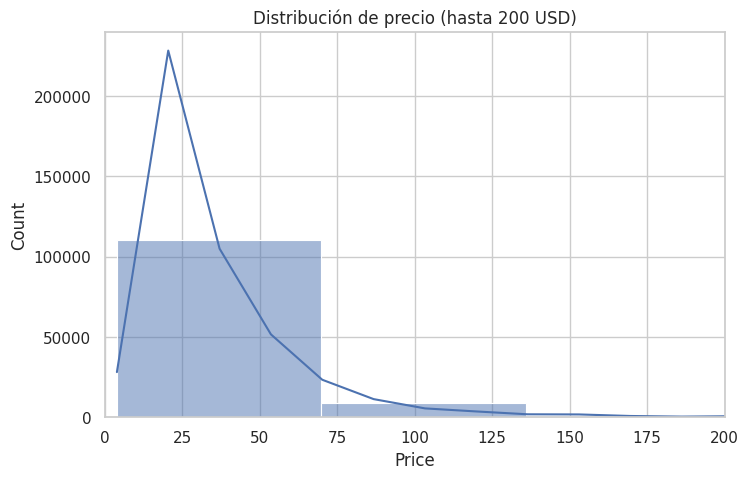

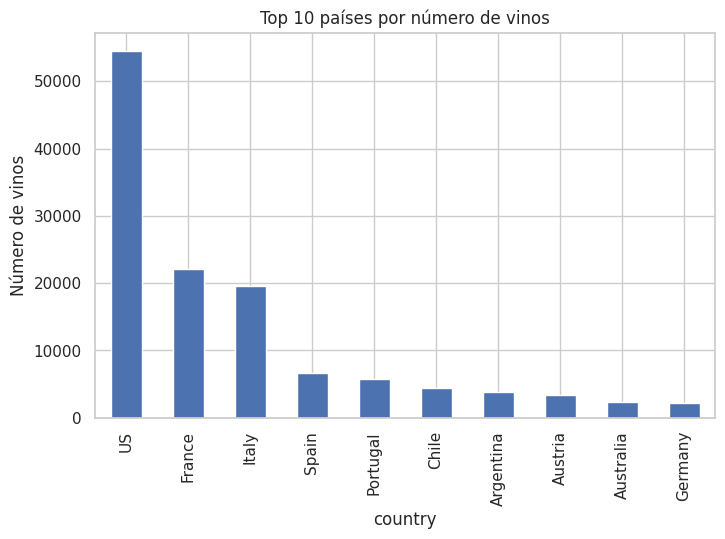

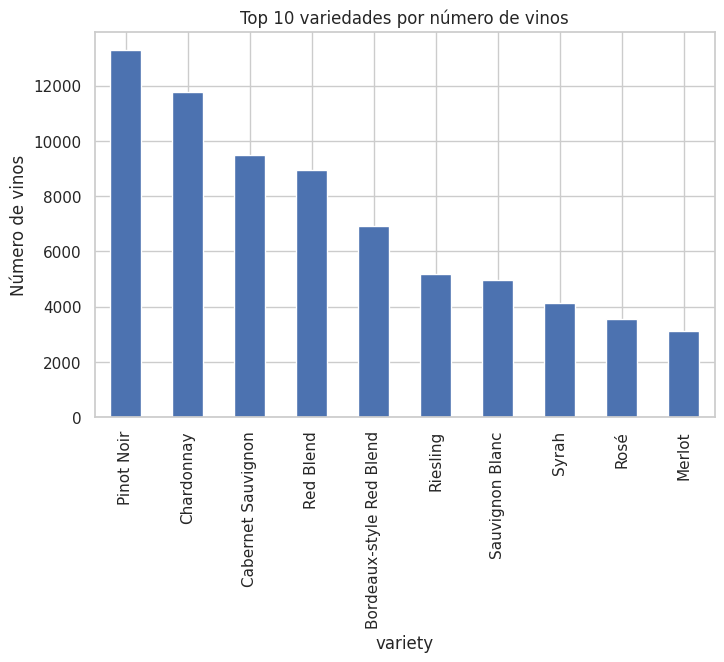

In [ ]:
# Info basica
df.info()

df.describe(include="all").transpose().head(15)

# Distribucion de calidad
plt.figure()
sns.histplot(df["points"], bins=20, kde=True)
plt.title("Distribución de puntajes (points)")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()

# Distribucion de precio
plt.figure()
sns.histplot(df["price"], bins=50, kde=True)
plt.xlim(0, 200)  # recortar por outliers muy caros
plt.title("Distribución de precio (hasta 200 USD)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Top paises por numero de vinos
plt.figure()
df["country"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 países por número de vinos")
plt.ylabel("Número de vinos")
plt.show()

# Top variedades por numero de vinos
plt.figure()
df["variety"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 variedades por número de vinos")
plt.ylabel("Número de vinos")
plt.show()

### Preprocesamiento

In [ ]:
# Columnas a utilizar
cols = ["points", "price", "country", "province", "variety"]
data = df[cols].copy()

# Descartamos los datos que no tengan puntos ni precio
data = data.dropna(subset=["points", "price"])

data.isna().sum()

,0
points,0
price,0
country,59
province,59
variety,1


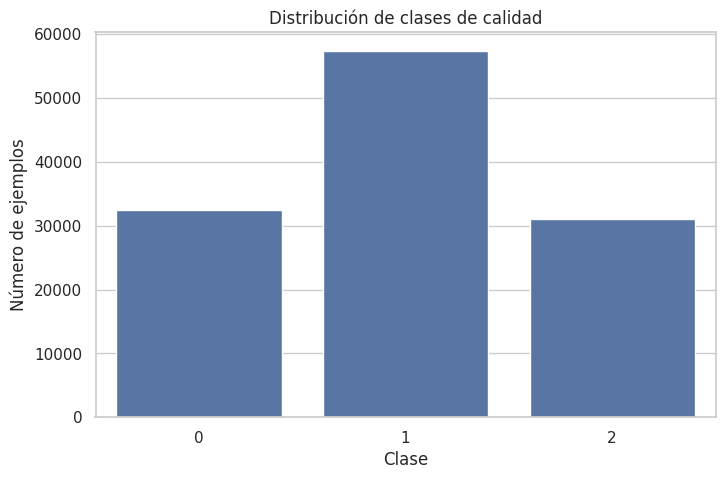

In [ ]:
def quality_to_class(points):
    """
    Convierte puntaje en categoría:
    0: 80-86
    1: 87-90
    2: 91+
    """
    if points <= 86:
        return 0
    elif points <= 90:
        return 1
    else:
        return 2

data["quality_class"] = data["points"].apply(quality_to_class)
data["quality_class"].value_counts()

# Visualizar balance de clases
plt.figure()
sns.countplot(x="quality_class", data=data)
plt.title("Distribución de clases de calidad")
plt.xlabel("Clase")
plt.ylabel("Número de ejemplos")
plt.show()

In [ ]:
# Reducir cardinalidad de categorías

def reduce_cardinality(series, top_n=20, other_label="Other"):
    top = series.value_counts().index[:top_n]
    return series.where(series.isin(top), other_label)

data["country_reduced"] = reduce_cardinality(data["country"], top_n=20)
data["province_reduced"] = reduce_cardinality(data["province"], top_n=20)
data["variety_reduced"] = reduce_cardinality(data["variety"], top_n=30)

data[["country_reduced", "province_reduced", "variety_reduced"]].head()


# Columnas como features
feature_cols_cat = ["country_reduced", "province_reduced", "variety_reduced"]
feature_cols_num = ["price"]

# Copia de trabajo
model_data = data[feature_cols_num + feature_cols_cat + ["quality_class"]].copy()

model_data["price_log"] = np.log1p(model_data["price"])
model_data = model_data.drop(columns=["price"])
feature_cols_num = ["price_log"]

model_data.head()

model_data_encoded = pd.get_dummies(
    model_data,
    columns=feature_cols_cat,
    drop_first=True
)

model_data_encoded.head()

,quality_class,price_log,country_reduced_Australia,country_reduced_Austria,country_reduced_Bulgaria,country_reduced_Canada,country_reduced_Chile,country_reduced_France,country_reduced_Germany,country_reduced_Greece,...,variety_reduced_Rosé,variety_reduced_Sangiovese,variety_reduced_Sauvignon Blanc,variety_reduced_Shiraz,variety_reduced_Sparkling Blend,variety_reduced_Syrah,variety_reduced_Tempranillo,variety_reduced_Viognier,variety_reduced_White Blend,variety_reduced_Zinfandel
1,1,2.772589,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,2.708050,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,2.639057,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,4.189655,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,1,2.772589,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Division train / val / test
X = model_data_encoded.drop(columns=["quality_class"])
y = model_data_encoded["quality_class"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,
    random_state=RANDOM_SEED,
    stratify=y_train_val
)

X_train.shape, X_val.shape, X_test.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y))
input_dim, num_classes

(71, 3)

### DataSet y DataLoader

In [ ]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WineDataset(X_train_scaled, y_train)
val_dataset   = WineDataset(X_val_scaled,   y_val)
test_dataset  = WineDataset(X_test_scaled,  y_test)

BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

### Definicion del MLP y configuracion de entrenamiento

In [ ]:
class MLPWine(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, num_classes=3, dropout_p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLPWine(input_dim=input_dim, num_classes=num_classes)
model

MLPWine(
  (net): Sequential(
    (0): Linear(in_features=71, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 20

### Loop de entrenamiento

In [ ]:
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).float().sum()
    return correct / len(labels)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    train_losses = []
    train_accs = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(compute_accuracy(outputs, y_batch).item())

    # --- Validation ---
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_losses.append(loss.item())
            val_accs.append(compute_accuracy(outputs, y_batch).item())

    train_loss = np.mean(train_losses)
    val_loss   = np.mean(val_losses)
    train_acc  = np.mean(train_accs)
    val_acc    = np.mean(val_accs)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} - "
          f"Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - "
          f"Train acc: {train_acc:.4f} - Val acc: {val_acc:.4f}")

Epoch 01/20 - Train loss: 0.8850 - Val loss: 0.8223 - Train acc: 0.5646 - Val acc: 0.6022
Epoch 02/20 - Train loss: 0.8309 - Val loss: 0.8157 - Train acc: 0.6006 - Val acc: 0.6090
Epoch 03/20 - Train loss: 0.8216 - Val loss: 0.8132 - Train acc: 0.6052 - Val acc: 0.6102
Epoch 04/20 - Train loss: 0.8191 - Val loss: 0.8124 - Train acc: 0.6068 - Val acc: 0.6088
Epoch 05/20 - Train loss: 0.8165 - Val loss: 0.8084 - Train acc: 0.6093 - Val acc: 0.6131
Epoch 06/20 - Train loss: 0.8155 - Val loss: 0.8084 - Train acc: 0.6085 - Val acc: 0.6131
Epoch 07/20 - Train loss: 0.8131 - Val loss: 0.8086 - Train acc: 0.6119 - Val acc: 0.6106
Epoch 08/20 - Train loss: 0.8118 - Val loss: 0.8078 - Train acc: 0.6103 - Val acc: 0.6147
Epoch 09/20 - Train loss: 0.8113 - Val loss: 0.8072 - Train acc: 0.6109 - Val acc: 0.6158
Epoch 10/20 - Train loss: 0.8095 - Val loss: 0.8076 - Train acc: 0.6134 - Val acc: 0.6125
Epoch 11/20 - Train loss: 0.8100 - Val loss: 0.8075 - Train acc: 0.6114 - Val acc: 0.6119
Epoch 12/2

### Curvas de entrenamiento

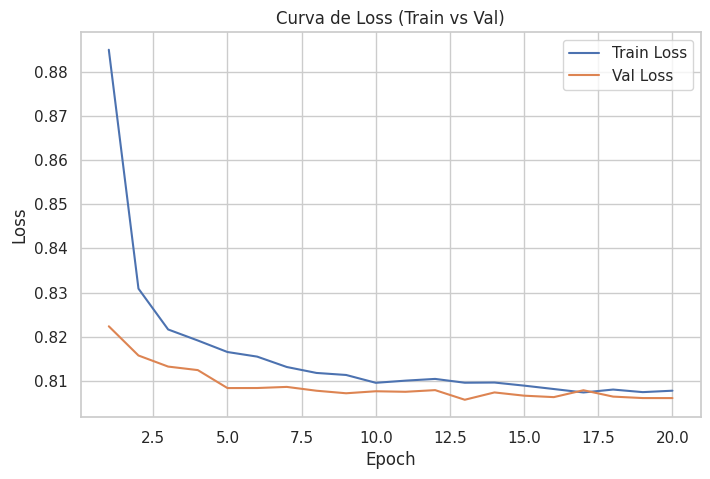

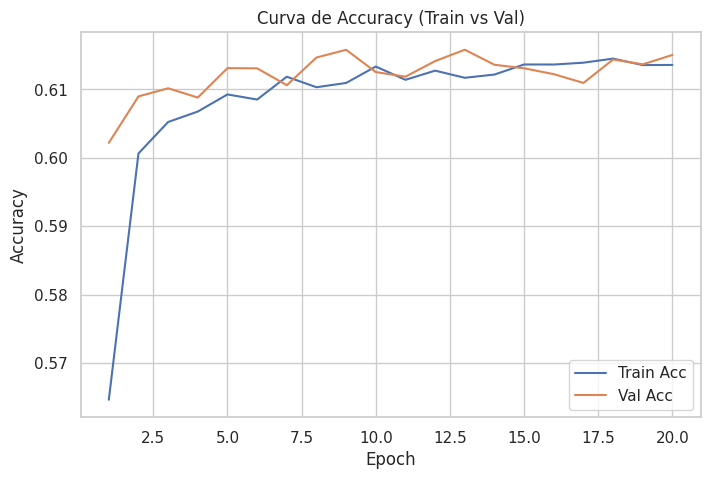

In [ ]:
epochs_range = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss (Train vs Val)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy (Train vs Val)")
plt.legend()
plt.show()

### Test evaluation

In [ ]:
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        all_logits.append(outputs.cpu())
        all_labels.append(y_batch)

all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

y_pred = torch.argmax(all_logits, dim=1).numpy()
y_true = all_labels.numpy()

acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print("Test Accuracy:", acc)
print("Test Precision (weighted):", precision)
print("Test Recall (weighted):", recall)
print("Test F1-score (weighted):", f1)

print("\nClassification report (por clase):")
print(classification_report(y_true, y_pred, digits=4))

Test Accuracy: 0.6153634209511214
Test Precision (weighted): 0.6244572035472209
Test Recall (weighted): 0.6153634209511214
Test F1-score (weighted): 0.6098584833891552

Classification report (por clase):
              precision    recall  f1-score   support

           0     0.6707    0.4528    0.5406      4872
           1     0.5868    0.7316    0.6512      8620
           2     0.6458    0.5704    0.6057      4655

    accuracy                         0.6154     18147
   macro avg     0.6344    0.5849    0.5992     18147
weighted avg     0.6245    0.6154    0.6099     18147



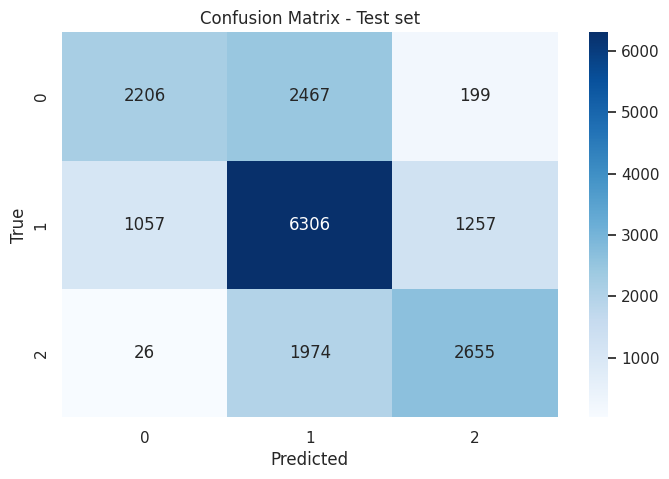

In [ ]:
# Matriz de confusion

cm = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test set")
plt.show()

### Ejemplos de predicciones

In [ ]:
test_indices = X_test.index.to_list()

results_df = pd.DataFrame({
    "idx": test_indices,
    "true_class": y_true,
    "pred_class": y_pred
})

sample_info = data.loc[results_df["idx"], ["country", "province", "variety", "price", "points"]].reset_index(drop=True)
results_full = pd.concat([results_df.reset_index(drop=True), sample_info], axis=1)

print("=== Ejemplos de predicciones correctas ===")
correct_examples = results_full[results_full["true_class"] == results_full["pred_class"]].head(5)
display(correct_examples)

print("\n=== Ejemplos de predicciones incorrectas ===")
wrong_examples = results_full[results_full["true_class"] != results_full["pred_class"]].head(5)
display(wrong_examples)

=== Ejemplos de predicciones correctas ===


,idx,true_class,pred_class,country,province,variety,price,points
1,123199,0,0,Spain,Catalonia,White Blend,15.0,86
2,14201,1,1,Spain,Northern Spain,Tempranillo,25.0,89
3,100154,1,1,US,America,Red Blend,50.0,90
5,35368,2,2,US,Oregon,Pinot Noir,65.0,92
6,94983,0,0,Portugal,Tejo,Portuguese Red,10.0,85



=== Ejemplos de predicciones incorrectas ===


,idx,true_class,pred_class,country,province,variety,price,points
0,41603,1,0,Spain,Catalonia,Trepat,16.0,88
4,3148,1,0,Argentina,Other,Torrontés,12.0,89
7,70501,1,2,US,California,Chardonnay,50.0,90
10,61735,0,1,US,California,Sangiovese,32.0,85
12,38153,2,1,Italy,Northeastern Italy,Sauvignon,44.0,91


## Resumen, analisis y conclusiones

La arquitectura del MLP es la siguiente:

- **Entrada:** vector numérico de tamaño `input_dim`, obtenido a partir de:
  - `price_log` estandarizado.
  - One-hot encoding de `country_reduced`, `province_reduced`, `variety_reduced`.
- **Capa oculta 1:** Linear(`input_dim` → 128) + ReLU + Dropout(0.3)
- **Capa oculta 2:** Linear(128 → 64) + ReLU + Dropout(0.3)
- **Capa de salida:** Linear(64 → 3), donde 3 es el número de clases de calidad.

**Función de pérdida:** CrossEntropyLoss  
**Optimizador:** Adam (learning rate = 1e-3)  
**Batch size:** 256  
**Épocas:** 20

### Interpretación de Resultados

- La accuracy en el conjunto de test fue de: 0.6153634209511214
- El modelo logra distinguir razonablemente entre las clases de calidad, pero hay
  cierta confusión entre las clases intermedias (por ejemplo, entre 0 y 1, o 1 y 2).

### Limitaciones del Modelo

- Solo se utilizan campos muy simples (país, provincia, variedad, precio).
- Las clases (0/1/2) están definidas manualmente, otras clasificaciones podrían
  ser más apropiadas.

### Posibles Mejoras

- Incluir características de **procesamiento de lenguaje natural (NLP)** a partir de la columna `description`.
- Probar arquitecturas más profundas o añadir **Batch Normalization** entre capas.
- Ajustar hiperparámetros: número de capas, neuronas, learning rate, épocas, etc.
- Comparar este MLP con otros modelos.